In [ ]:
import torch
from torch import nn, Tensor
import torch.nn.functional as functional
from torchvision.datasets import CIFAR100
import pandas as pd
from torchvision import transforms
from torchvision.transforms import v2, AutoAugment, AutoAugmentPolicy
from torch.backends import cudnn
from torch import GradScaler
from torch import optim
from tqdm import tqdm
from torchvision.models import resnet18
import time
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.v2 import CutMix, MixUp
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from timm import create_model
import numpy as np
import os

class CIFAR100N(Dataset):
    def __init__(self, root, transform=None, noise_file='./drive/MyDrive/data/CIFAR-100_human.pt'):
        self.cifar100 = CIFAR100(root=root, train=True, download=True, transform=transform)
        noise_data = torch.load(noise_file)
        self.labels = noise_data['noisy_label']
    def __len__(self):
        return len(self.cifar100)

    def __getitem__(self, idx):
        image, _ = self.cifar100[idx]
        label = self.labels[idx]
        return image, label

def evaluate_noisiness(model, loader, device):
    model.eval()
    noisiness_scores = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            max_probs, _ = probs.max(dim=1)
            noisiness_scores.extend(1 - max_probs.cpu().numpy())

    return noisiness_scores

def train(model, loader, optimizer, criterion, device, augmentation):
    model.train()
    correct = 0
    total = 0
    total_loss = 0.0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        if augmentation:
            images, labels = augmentation(images, labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        labels = labels.argmax(dim=1) if labels.ndim > 1 else labels
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total

    return accuracy, avg_loss

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        labels_smooth = labels.argmax(dim=1) if labels.ndim > 1 else labels
        correct += predicted.eq(labels_smooth).sum().item()
        total += labels.size(0)

    return total_loss / total, 100.0 * correct / total

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])
    train_dataset = CIFAR100N(root='./drive/MyDrive/data', transform=transform, noise_file='./drive/MyDrive/data/CIFAR-100_human.pt')
    test_dataset = CIFAR100(root='./drive/MyDrive/data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4,
                              persistent_workers=True, prefetch_factor=2)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4,
                             persistent_workers=True, prefetch_factor=2)

    initial_model = resnet18(weights="IMAGENET1K_V1")
    initial_model.fc = nn.Linear(initial_model.fc.in_features, 100)
    initial_model = initial_model.to(device)

    initial_optimizer = optim.SGD(initial_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    initial_criterion = nn.CrossEntropyLoss()

    for epoch in range(10):
        train(initial_model, train_loader, initial_optimizer, initial_criterion, device, augmentation=None)

    noisiness_scores = evaluate_noisiness(initial_model, train_loader, device)

    threshold = np.percentile(noisiness_scores, 75)
    noisy_indices = np.where(np.array(noisiness_scores) > threshold)[0]

    class NoisyCIFAR100N(Dataset):
        def __init__(self, dataset, noisy_indices, noise_prob=0.2):
            self.dataset = dataset
            self.noisy_indices = noisy_indices
            self.noise_prob = noise_prob

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            image, label = self.dataset[idx]
            if idx not in self.noisy_indices and np.random.rand() < self.noise_prob:
                label = np.random.randint(0, 100)
            return image, label

    final_train_dataset = NoisyCIFAR100N(train_dataset, noisy_indices, noise_prob=0.2)
    final_train_loader = DataLoader(final_train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)

    model = resnet18(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, 100)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

    cutmix = CutMix(num_classes=100, alpha=1.0)
    mixup = MixUp(num_classes=100, alpha=1.0)

    num_epochs = 15
    best_acc = 0.0

    for epoch in range(num_epochs):

        start_time = time.time()
        print(f"Epoch {epoch + 1}/{num_epochs}")

        augmentation = cutmix if np.random.rand() < 0.5 else mixup

        train_loss, train_acc = train(
            model, final_train_loader, optimizer, criterion, device, augmentation
        )

        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        scheduler.step()

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Time taken: {time.time() - start_time:.2f}s")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_resnet_dividemix.pth')

    print(f"Best Validation Accuracy: {best_acc:.2f}%")


Files already downloaded and verified


<ipython-input-5-bfa99ee1d38d>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noise_data = torch.load(noise_file)


Files already downloaded and verified
Epoch 1/100
Train Loss: 20.2800, Train Acc: 3.87%, Val Loss: 1.9097, Val Acc: 53.52%
Time taken: 79.21s
Epoch 2/100
Train Loss: 33.0720, Train Acc: 3.51%, Val Loss: 1.8687, Val Acc: 58.23%
Time taken: 79.49s
Epoch 3/100
Train Loss: 31.9620, Train Acc: 3.47%, Val Loss: 1.6420, Val Acc: 61.26%
Time taken: 79.01s
Epoch 4/100
Train Loss: 33.8440, Train Acc: 3.41%, Val Loss: 1.5653, Val Acc: 64.81%
Time taken: 79.02s
Epoch 5/100
Train Loss: 37.8620, Train Acc: 3.35%, Val Loss: 1.7186, Val Acc: 63.54%
Time taken: 79.43s
Epoch 6/100
Train Loss: 36.0760, Train Acc: 3.34%, Val Loss: 1.5282, Val Acc: 65.79%
Time taken: 79.06s
Epoch 7/100
Train Loss: 39.9720, Train Acc: 3.26%, Val Loss: 1.6235, Val Acc: 64.86%
Time taken: 79.47s
Epoch 8/100
Train Loss: 37.2560, Train Acc: 3.28%, Val Loss: 1.4913, Val Acc: 65.86%
Time taken: 78.79s
Epoch 9/100
Train Loss: 38.1080, Train Acc: 3.24%, Val Loss: 1.5489, Val Acc: 66.19%
Time taken: 78.98s
Epoch 10/100
Train Loss: 4

In [ ]:
import random

import torch
from torch import nn, Tensor
import torch.nn.functional as functional
from torchvision.datasets import CIFAR100
import pandas as pd
from torchvision import transforms
from torchvision.transforms import v2, AutoAugment, AutoAugmentPolicy
from torch.backends import cudnn
from torch import GradScaler
from torch import optim
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from timm import create_model
import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
cudnn.benchmark = True


class CachedDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.data = [(image, label) for image, label in dataset]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return image, label


class CIFAR100N(Dataset):
    def __init__(self, root, transform=None, noisy_labels=None):
        self.cifar100 = CIFAR100(root=root, train=True, download=True, transform=transform)
        self.noisy_labels = torch.tensor(noisy_labels, dtype=torch.long)  # Convert to tensor

    def __len__(self):
        return len(self.cifar100)

    def __getitem__(self, idx):
        image, _ = self.cifar100[idx]
        label = self.noisy_labels[idx]
        return image, label

    def check_noise_percentage(self):
        """
        Check the percentage of noisy labels in the dataset.
        """
        clean_labels = torch.tensor(self.cifar100.targets)
        noisy_labels = torch.tensor(self.noisy_labels)
        assert len(clean_labels) == len(noisy_labels), "Mismatch in label lengths"

        mismatches = (clean_labels != noisy_labels).sum().item()
        total_labels = len(clean_labels)

        noise_percentage = (mismatches / total_labels) * 100
        print(f"Noise Percentage: {noise_percentage:.2f}%")
        return noise_percentage


def create_plots():
    epochs_range = list(range(1, EPOC + 1))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker='o')
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='x')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs_range, val_losses, label="Validation Loss", marker='x')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    noise_file_path = './drive/MyDrive/data/CIFAR-100_human.pt'
    noise_data = torch.load(noise_file_path)
    noisy_labels = noise_data['noisy_label']

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        # transforms.RandomRotation(degrees=15),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    train_set = CIFAR100N(
        root='./drive/MyDrive/data',
        # root='/kaggle/input/fii-atnn-2024-assignment-2',

        transform=train_transform,
        noisy_labels=noisy_labels
    )

    test_set = CIFAR100(
        root='./drive/MyDrive/data',
        # root='/kaggle/input/fii-atnn-2024-assignment-2',

        train=False,
        download=True,
        transform=test_transform
    )


    noise_percentage = train_set.check_noise_percentage()
    print(f"The dataset contains {noise_percentage:.2f}% noisy labels.")

    assert len(train_set) == 50000, "Dataset length mismatch!"

    train_loader = DataLoader(train_set, batch_size=256, shuffle=True, pin_memory=True, num_workers=4,
                              persistent_workers=True, prefetch_factor=2)

    test_loader = DataLoader(test_set, batch_size=256, pin_memory=True, num_workers=4, persistent_workers=True,
                             prefetch_factor=2)

    EPOC = 10
    import torch
    import torch.nn as nn

    # model = create_model("resnet34", pretrained=True, num_classes=100)
    model = create_model("resnet50", pretrained=True, num_classes=100)

    print(model.pretrained_cfg)

    model = model.to('cuda')


    class LabelSmoothingLoss(nn.Module):
        def __init__(self, num_classes, smoothing=0.1):
            super(LabelSmoothingLoss, self).__init__()
            self.smoothing = smoothing
            self.num_classes = num_classes

        def forward(self, preds, targets):
            if targets.dtype == torch.float:
                smooth_labels = targets
            else:
                one_hot = torch.zeros_like(preds).scatter(1, targets.unsqueeze(1), 1)
                smooth_labels = (1 - self.smoothing) * one_hot + self.smoothing / self.num_classes

            log_probs = torch.log_softmax(preds, dim=1)
            return -torch.mean(torch.sum(smooth_labels * log_probs, dim=1))


    criterion = LabelSmoothingLoss(num_classes=100, smoothing=0.1)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOC)

    # scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #     optimizer,
    #     max_lr=0.001,  # Peak learning rate
    #     steps_per_epoch=len(train_loader),
    #     epochs=EPOC
    # )

    # scheduler = torch.optim.lr_scheduler.SequentialLR(
    #     optimizer,
    #     schedulers=[
    #         torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=5),  # Warmup for 5 epochs
    #         torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOC - 5)  # Cosine decay
    #     ],
    #     milestones=[5]
    # )

    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    cutMix = v2.CutMix(num_classes=100, alpha=1.0)
    mixUp = v2.MixUp(num_classes=100, alpha=1.0)

    rand_choice = v2.RandomChoice([cutMix, mixUp])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # scaler = GradScaler(enabled=torch.cuda.is_available())
    enable_half = True  # Disable for CPU, it is slower!


    # = torch.cuda.is_available()

    def train_one_epoch(epoch):
        model.train()
        correct, total, total_loss = 0, 0, 0.0

        batch_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

        for inputs, targets in batch_bar:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            # inputs, targets = rand_choice(inputs, targets)  # MixUp or CutMix

            if epoch < EPOC // 2:
                inputs, targets = mixUp(inputs, targets)
            else:
                inputs, targets = cutMix(inputs, targets)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Use updated criterion

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate metrics
            total_loss += loss.item() * inputs.size(0)
            predicted = outputs.argmax(1)
            total += targets.size(0)

            # For MixUp or CutMix, calculate accuracy on the weighted label distribution
            if isinstance(targets, Tensor):
                # Convert targets to one-hot
                correct += (predicted == targets.argmax(1)).sum().item()

            avg_loss = total_loss / total
            accuracy = 100.0 * correct / total
            batch_bar.set_postfix({
                "Batch Loss": f"{loss.item():.4f}",
                "Epoch Loss": f"{avg_loss:.4f}",
                "Accuracy": f"{accuracy:.2f}%"
            })

        avg_loss = total_loss / total
        accuracy = 100.0 * correct / total
        return accuracy, avg_loss


    @torch.no_grad()
    def evaluate():
        model.eval()
        correct = 0
        total = 0
        total_loss = 0.0

        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = functional.cross_entropy(outputs, targets)

            total_loss += loss.item() * inputs.size(0)
            predicted = outputs.argmax(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        avg_loss = total_loss / total
        accuracy = 100.0 * correct / total
        return accuracy, avg_loss


    @torch.inference_mode()
    def inference():
        model.eval()

        labels = []

        for inputs, _ in test_loader:
            inputs = inputs.to(device, non_blocking=True)
            with torch.autocast(device.type, enabled=enable_half):
                outputs = model(inputs)

            predicted = outputs.argmax(1).tolist()
            labels.extend(predicted)

        return labels


    # Training Loop
    best_model_state = model.state_dict()
    best_val_accuracy = 0.0

    print("Starting training...")
    for epoch in range(EPOC):
        train_acc, train_loss = train_one_epoch(epoch)
        val_acc, val_loss = evaluate()

        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        scheduler.step()

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model_state = model.state_dict()

        print(
            f"\nEpoch {epoch + 1}/{EPOC} - Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Best Val Acc: {best_val_accuracy:.2f}%")
        print()

    torch.save(best_model_state, f"best_model_here.pth")
    create_plots()

    data = {
        "ID": [],
        "target": []
    }

    for i, label in enumerate(inference()):
        data["ID"].append(i)
        data["target"].append(label)

    df = pd.DataFrame(data)
    # df.to_csv(f"submission{time.strftime("%A %H:%M:%S")}.csv", index=False)

<ipython-input-3-7ef667718512>:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noise_data = torch.load(noise_file_path)


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-3-7ef667718512>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_labels = torch.tensor(self.noisy_labels)


Noise Percentage: 40.20%
The dataset contains 40.20% noisy labels.
{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth', 'hf_hub_id': 'timm/resnet50.a1_in1k', 'architecture': 'resnet50', 'tag': 'a1_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'test_input_size': (3, 288, 288), 'fixed_input_size': False, 'interpolation': 'bicubic', 'crop_pct': 0.95, 'test_crop_pct': 1.0, 'crop_mode': 'center', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'num_classes': 1000, 'pool_size': (7, 7), 'first_conv': 'conv1', 'classifier': 'fc', 'origin_url': 'https://github.com/huggingface/pytorch-image-models', 'paper_ids': 'arXiv:2110.00476'}


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

<ipython-input-2-7a7fefda6c28>:202: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noise_data = torch.load(noise_file_path)


Files already downloaded and verified
Files already downloaded and verified
Noise Percentage: 40.20%
The dataset contains 40.20% noisy labels.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Starting Co-Teaching training...


Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]<ipython-input-2-7a7fefda6c28>:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-2-7a7fefda6c28>:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1: 100%|██████████| 391/391 [01:37<00:00,  4.01it/s, Model1 Loss=3.0201, Model2 Loss=3.1699, Model1 Acc=16.36%, Model2 Acc=15.13%]


Epoch 1:
Model1 - Train Loss: 3.9239, Train Acc: 16.36%, Val Acc: 30.85%
Model2 - Train Loss: 3.9600, Train Acc: 15.13%, Val Acc: 28.74%


Epoch 2: 100%|██████████| 391/391 [01:36<00:00,  4.07it/s, Model1 Loss=3.3789, Model2 Loss=3.3648, Model1 Acc=36.66%, Model2 Acc=35.91%]


Epoch 2:
Model1 - Train Loss: 3.0783, Train Acc: 36.66%, Val Acc: 47.99%
Model2 - Train Loss: 3.1144, Train Acc: 35.91%, Val Acc: 46.55%


Epoch 3: 100%|██████████| 391/391 [01:38<00:00,  3.98it/s, Model1 Loss=2.5119, Model2 Loss=2.5279, Model1 Acc=42.97%, Model2 Acc=42.34%]


Epoch 3:
Model1 - Train Loss: 2.8293, Train Acc: 42.97%, Val Acc: 54.58%
Model2 - Train Loss: 2.8477, Train Acc: 42.34%, Val Acc: 53.85%


Epoch 4: 100%|██████████| 391/391 [01:39<00:00,  3.93it/s, Model1 Loss=3.5192, Model2 Loss=3.4876, Model1 Acc=44.59%, Model2 Acc=44.48%]


Epoch 4:
Model1 - Train Loss: 2.7784, Train Acc: 44.59%, Val Acc: 58.50%
Model2 - Train Loss: 2.7868, Train Acc: 44.48%, Val Acc: 58.39%


Epoch 5: 100%|██████████| 391/391 [01:41<00:00,  3.86it/s, Model1 Loss=2.7964, Model2 Loss=2.7542, Model1 Acc=46.52%, Model2 Acc=46.54%]


Epoch 5:
Model1 - Train Loss: 2.7179, Train Acc: 46.52%, Val Acc: 60.55%
Model2 - Train Loss: 2.7248, Train Acc: 46.54%, Val Acc: 60.60%


Epoch 6: 100%|██████████| 391/391 [01:42<00:00,  3.80it/s, Model1 Loss=2.8109, Model2 Loss=2.7760, Model1 Acc=42.30%, Model2 Acc=42.17%]


Epoch 6:
Model1 - Train Loss: 2.7500, Train Acc: 42.30%, Val Acc: 62.88%
Model2 - Train Loss: 2.7562, Train Acc: 42.17%, Val Acc: 62.79%


Epoch 7: 100%|██████████| 391/391 [01:44<00:00,  3.73it/s, Model1 Loss=2.8924, Model2 Loss=2.9217, Model1 Acc=42.46%, Model2 Acc=42.25%]


Epoch 7:
Model1 - Train Loss: 2.6892, Train Acc: 42.46%, Val Acc: 64.20%
Model2 - Train Loss: 2.6967, Train Acc: 42.25%, Val Acc: 64.03%


Epoch 8: 100%|██████████| 391/391 [01:46<00:00,  3.67it/s, Model1 Loss=3.1336, Model2 Loss=3.1376, Model1 Acc=43.36%, Model2 Acc=43.16%]


Epoch 8:
Model1 - Train Loss: 2.7017, Train Acc: 43.36%, Val Acc: 64.75%
Model2 - Train Loss: 2.7094, Train Acc: 43.16%, Val Acc: 64.55%


Epoch 9: 100%|██████████| 391/391 [01:47<00:00,  3.63it/s, Model1 Loss=2.9367, Model2 Loss=2.9678, Model1 Acc=42.66%, Model2 Acc=42.67%]


Epoch 9:
Model1 - Train Loss: 2.7307, Train Acc: 42.66%, Val Acc: 65.06%
Model2 - Train Loss: 2.7360, Train Acc: 42.67%, Val Acc: 65.24%


Epoch 10: 100%|██████████| 391/391 [01:49<00:00,  3.58it/s, Model1 Loss=2.9741, Model2 Loss=2.9875, Model1 Acc=41.87%, Model2 Acc=41.60%]


Epoch 10:
Model1 - Train Loss: 2.8123, Train Acc: 41.87%, Val Acc: 65.09%
Model2 - Train Loss: 2.8211, Train Acc: 41.60%, Val Acc: 65.12%


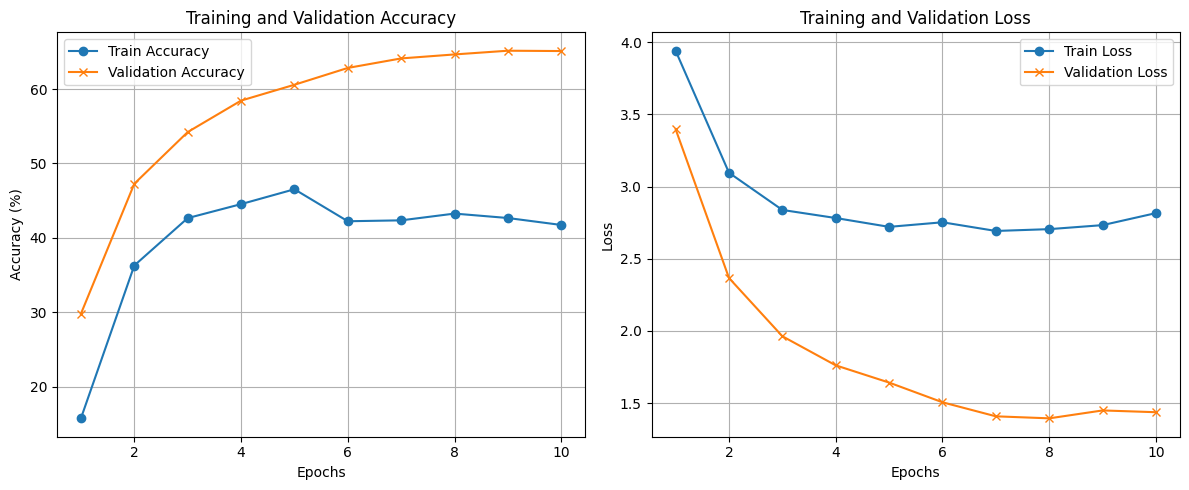

Training complete. Best Validation Accuracy: 65.24


In [ ]:
import random

import torch
from torch import nn, Tensor
import torch.nn.functional as functional
from torchvision.datasets import CIFAR100
import pandas as pd
from torchvision import transforms
from torchvision.transforms import v2, AutoAugment, AutoAugmentPolicy, Resize
from torch.backends import cudnn
from torch import GradScaler
from torch import optim
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from timm import create_model
import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CachedDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.data = [(image, label) for image, label in dataset]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return image, label


class CIFAR100N(Dataset):
    def __init__(self, root, transform=None, noisy_labels=None, image_size=(224, 224)):
        self.cifar100 = CIFAR100(root=root, train=True, download=True, transform=None)
        self.noisy_labels = torch.tensor(noisy_labels, dtype=torch.long)
        self.resize_transform = Resize(image_size)
        self.additional_transform = transform

    def __len__(self):
        return len(self.cifar100)

    def __getitem__(self, idx):
        image, _ = self.cifar100[idx]
        image = self.resize_transform(image)
        if self.additional_transform:
            image = self.additional_transform(image)
        label = self.noisy_labels[idx]
        return image, label

    def check_noise_percentage(self):
        clean_labels = torch.tensor(self.cifar100.targets)
        noisy_labels = self.noisy_labels
        assert len(clean_labels) == len(noisy_labels), "Mismatch in label lengths"

        mismatches = (clean_labels != noisy_labels).sum().item()
        total_labels = len(clean_labels)

        noise_percentage = (mismatches / total_labels) * 100
        print(f"Noise Percentage: {noise_percentage:.2f}%")
        return noise_percentage


def create_plots():
    epochs_range = list(range(1, EPOC + 1))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker='o')
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='x')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs_range, val_losses, label="Validation Loss", marker='x')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


# Co-Teaching Training Function
def train_one_epoch(epoch, model1, model2, optimizer1, optimizer2, criterion, train_loader, tau):
    model1.train()
    model2.train()

    # MixUp and CutMix setup
    cutMix = v2.CutMix(num_classes=100, alpha=1.0)
    mixUp = v2.MixUp(num_classes=100, alpha=1.0)

    correct1, correct2 = 0, 0
    total, total_loss1, total_loss2 = 0, 0.0, 0.0

    batch_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

    for inputs, targets in batch_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        if epoch < EPOC // 2:
            inputs, targets = mixUp(inputs, targets)
        else:
            inputs, targets = cutMix(inputs, targets)

        with torch.cuda.amp.autocast():
            outputs1 = model1(inputs)
            outputs2 = model2(inputs)

            loss1 = functional.cross_entropy(outputs1, targets, reduction='none')
            loss2 = functional.cross_entropy(outputs2, targets, reduction='none')

            _, indices1 = torch.topk(loss1, int((1 - tau) * len(loss1)), largest=False)
            _, indices2 = torch.topk(loss2, int((1 - tau) * len(loss2)), largest=False)

            clean_inputs1, clean_targets1 = inputs[indices2], targets[indices2]
            clean_inputs2, clean_targets2 = inputs[indices1], targets[indices1]

        optimizer1.zero_grad()
        optimizer2.zero_grad()

        with torch.cuda.amp.autocast():
            clean_outputs1 = model1(clean_inputs1)
            clean_outputs2 = model2(clean_inputs2)

            clean_loss1 = criterion(clean_outputs1, clean_targets1)
            clean_loss2 = criterion(clean_outputs2, clean_targets2)

        scaler.scale(clean_loss1).backward()
        scaler.scale(clean_loss2).backward()

        torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1.0)

        scaler.step(optimizer1)
        scaler.step(optimizer2)
        scaler.update()

        total_loss1 += clean_loss1.item() * clean_inputs1.size(0)
        total_loss2 += clean_loss2.item() * clean_inputs2.size(0)

        predicted1 = clean_outputs1.argmax(dim=1)
        predicted2 = clean_outputs2.argmax(dim=1)

        correct1 += (predicted1 == clean_targets1.argmax(dim=1)).sum().item()
        correct2 += (predicted2 == clean_targets2.argmax(dim=1)).sum().item()

        total += clean_inputs1.size(0)

        batch_bar.set_postfix({
            "Model1 Loss": f"{clean_loss1.item():.4f}",
            "Model2 Loss": f"{clean_loss2.item():.4f}",
            "Model1 Acc": f"{100.0 * correct1 / total:.2f}%",
            "Model2 Acc": f"{100.0 * correct2 / total:.2f}%"
        })

    avg_loss1 = total_loss1 / total
    avg_loss2 = total_loss2 / total
    acc1 = 100.0 * correct1 / total
    acc2 = 100.0 * correct2 / total

    return avg_loss1, avg_loss2, acc1, acc2


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total, total_loss = 0, 0, 0.0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = functional.cross_entropy(outputs, targets)

        total_loss += loss.item() * inputs.size(0)
        predicted = outputs.argmax(dim=1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return accuracy, avg_loss


if __name__ == '__main__':
    noise_file_path = 'drive/MyDrive/data/CIFAR-100_human.pt'
    noise_data = torch.load(noise_file_path)
    noisy_labels = noise_data['noisy_label']

    train_transform = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    train_set = CIFAR100N(
        root='./drive/MyDrive/data',
        transform=train_transform,
        noisy_labels=noisy_labels
    )

    test_set = CIFAR100(
        root='./drive/MyDrive/data',
        train=False,
        download=True,
        transform=test_transform
    )

    noise_percentage = train_set.check_noise_percentage()
    print(f"The dataset contains {noise_percentage:.2f}% noisy labels.")

    train_loader = DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True, num_workers=2,
                              persistent_workers=True)
    test_loader = DataLoader(test_set, batch_size=128, pin_memory=True, num_workers=2, persistent_workers=True)

    EPOC = 10

    model1 = create_model("resnet18", pretrained=True, num_classes=100).to(device)
    model2 = create_model("resnet18", pretrained=True, num_classes=100).to(device)

    # for param in model1.parameters():
    #     param.requires_grad = False  # Freeze earlier layers
    # for param in model1.fc.parameters():
    #     param.requires_grad = True  # Fine-tune the classifier
    #
    # for param in model2.parameters():
    #     param.requires_grad = False  # Freeze earlier layers
    # for param in model2.fc.parameters():
    #     param.requires_grad = True  # Fine-tune the classifier

    optimizer1 = torch.optim.AdamW(model1.parameters(), lr=0.0005, weight_decay=0.001)
    optimizer2 = torch.optim.AdamW(model2.parameters(), lr=0.0005, weight_decay=0.001)

    scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer1, T_max=EPOC)
    scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer2, T_max=EPOC)

    # scheduler1 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer1, T_0=5, T_mult=2)
    # scheduler2 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer2, T_0=5, T_mult=2)


    class LabelSmoothingLoss(nn.Module):
        def __init__(self, num_classes, smoothing=0.1):
            super(LabelSmoothingLoss, self).__init__()
            self.smoothing = smoothing
            self.num_classes = num_classes

        def forward(self, preds, targets):
            if targets.dtype == torch.float:
                smooth_labels = targets
            else:
                one_hot = torch.zeros_like(preds).scatter(1, targets.unsqueeze(1), 1)
                smooth_labels = (1 - self.smoothing) * one_hot + self.smoothing / self.num_classes

            log_probs = torch.log_softmax(preds, dim=1)
            return -torch.mean(torch.sum(smooth_labels * log_probs, dim=1))


    class SymmetricCrossEntropy(nn.Module):
        def __init__(self, alpha=0.1, beta=1.0):
            super().__init__()
            self.alpha = alpha
            self.beta = beta
            self.ce = nn.CrossEntropyLoss()

        def forward(self, preds, targets):
            ce_loss = self.ce(preds, targets)
            preds_softmax = torch.softmax(preds, dim=1)
            rce_loss = -torch.mean(torch.sum(preds_softmax * torch.log(preds_softmax + 1e-12), dim=1))
            return self.alpha * ce_loss + self.beta * rce_loss


    # criterion = SymmetricCrossEntropy(alpha=0.1, beta=1.0)
    criterion = nn.CrossEntropyLoss()

    # criterion = LabelSmoothingLoss(num_classes=100, smoothing=0.1)

    best_val_accuracy = 0.0

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    print("Starting Co-Teaching training...")
    for epoch in range(EPOC):
        tau = 0.2 * (1 - epoch / EPOC)

        scaler = GradScaler()

        train_loss1, train_loss2, train_acc1, train_acc2 = train_one_epoch(
            epoch, model1, model2, optimizer1, optimizer2, criterion, train_loader, tau
        )

        val_acc1, val_loss1 = evaluate(model1, test_loader)
        val_acc2, val_loss2 = evaluate(model2, test_loader)

        train_accuracies.append((train_acc1 + train_acc2) / 2)
        val_accuracies.append((val_acc1 + val_acc2) / 2)
        train_losses.append((train_loss1 + train_loss2) / 2)
        val_losses.append((val_loss1 + val_loss2) / 2)

        print(f"Epoch {epoch + 1}:\n"
              f"Model1 - Train Loss: {train_loss1:.4f}, Train Acc: {train_acc1:.2f}%, Val Acc: {val_acc1:.2f}%\n"
              f"Model2 - Train Loss: {train_loss2:.4f}, Train Acc: {train_acc2:.2f}%, Val Acc: {val_acc2:.2f}%")

        scheduler1.step()
        scheduler2.step()

        if val_acc1 > best_val_accuracy:
            best_val_accuracy = val_acc1
            torch.save(model1.state_dict(), "best_model1.pth")
        if val_acc2 > best_val_accuracy:
            best_val_accuracy = val_acc2
            torch.save(model2.state_dict(), "best_model2.pth")

    create_plots()
    print("Training complete. Best Validation Accuracy:", best_val_accuracy)

In [ ]:
# acum codul meu cu mixturi gaussiene

import torch
from torch import nn, Tensor
import torch.nn.functional as functional
from torchvision.datasets import CIFAR100
from torchvision import transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from torchvision.transforms.v2 import CutMix, MixUp
from torch.utils.data import Dataset, DataLoader
from timm import create_model
import numpy as np
import time
import matplotlib.pyplot as plt

class CIFAR100N(Dataset):
    def __init__(self, root, transform=None, noise_file='./drive/MyDrive/data/CIFAR-100_human.pt'):
        self.cifar100 = CIFAR100(root=root, train=True, download=True, transform=transform)
        noise_data = torch.load(noise_file)
        self.labels = noise_data['noisy_label']

    def __len__(self):
        return len(self.cifar100)

    def __getitem__(self, idx):
        image, _ = self.cifar100[idx]
        label = self.labels[idx]
        return image, label

def evaluate_noisiness(model, loader, device):
    model.eval()
    noisiness_scores = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            max_probs, _ = probs.max(dim=1)
            noisiness_scores.extend(1 - max_probs.cpu().numpy())

    return noisiness_scores

def train(model, loader, optimizer, criterion, device, augmentation):
    model.train()
    correct = 0
    total = 0
    total_loss = 0.0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        if augmentation:
            images, labels = augmentation(images, labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        labels = labels.argmax(dim=1) if labels.ndim > 1 else labels
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total

    return accuracy, avg_loss

def get_augmentations(noise_level):
    if noise_level == "low":
        return transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=10),
        ])
    elif noise_level == "medium":
        return transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
        ])
    elif noise_level == "high":
        return transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=30),
            transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
            transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)),
        ])
    else:
        return transforms.Compose([])

@torch.no_grad()
def evaluate_with_tta(model, loader, criterion, device, augmentation_policy):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        augmented_predictions = []
        for _ in range(5):
            augmented_images = torch.stack([augmentation_policy(img) for img in images.cpu()])
            augmented_images = augmented_images.to(device)

            outputs = model(augmented_images)
            augmented_predictions.append(torch.softmax(outputs, dim=1))

        final_predictions = torch.mean(torch.stack(augmented_predictions), dim=0)
        loss = criterion(final_predictions, labels)

        total_loss += loss.item() * images.size(0)
        _, predicted = final_predictions.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return total_loss / total, 100.0 * correct / total

def create_plots():
    epochs_range = list(range(1, num_epochs + 1))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker='o')
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='x')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs_range, val_losses, label="Validation Loss", marker='x')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])
    train_dataset = CIFAR100N(root='./drive/MyDrive/data', transform=transform, noise_file='./drive/MyDrive/data/CIFAR-100_human.pt')
    test_dataset = CIFAR100(root='./drive/MyDrive/data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

    initial_model = create_model('resnet18', pretrained=True, num_classes=100)
    initial_model = initial_model.to(device)

    initial_optimizer = torch.optim.SGD(initial_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    initial_criterion = nn.CrossEntropyLoss()

    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(10):
        train_acc, train_loss = train(initial_model, train_loader, initial_optimizer, initial_criterion, device, augmentation=None)
        val_loss, val_acc = evaluate_with_tta(initial_model, test_loader, initial_criterion, device, augmentation_policy=None)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    noisiness_scores = evaluate_noisiness(initial_model, train_loader, device)

    threshold = np.percentile(noisiness_scores, 75)
    noisy_indices = np.where(np.array(noisiness_scores) > threshold)[0]

    class NoisyCIFAR100N(Dataset):
        def __init__(self, dataset, noisy_indices, noise_prob=0.2):
            self.dataset = dataset
            self.noisy_indices = noisy_indices
            self.noise_prob = noise_prob

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            image, label = self.dataset[idx]
            if idx not in self.noisy_indices and np.random.rand() < self.noise_prob:
                label = np.random.randint(0, 100)
            return image, label

    final_train_dataset = NoisyCIFAR100N(train_dataset, noisy_indices, noise_prob=0.2)
    final_train_loader = DataLoader(final_train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)

    noise_percentile = np.percentile(noisiness_scores, [33, 66])

    noise_level = "low"
    if max(noisiness_scores) > noise_percentile[1]:
        noise_level = "high"
    elif max(noisiness_scores) > noise_percentile[0]:
        noise_level = "medium"

    augmentation_policy = get_augmentations(noise_level)


    model = create_model('resnet18', pretrained=True, num_classes=100)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

    num_epochs = 15
    best_acc = 0.0

    for epoch in range(num_epochs):

        start_time = time.time()
        print(f"Epoch {epoch + 1}/{num_epochs}")

        train_loss, train_acc = train(
            model, final_train_loader, optimizer, criterion, device, augmentation=None
        )

        if augmentation_policy is None:
            augmentation_policy = get_augmentations("low")

        # val_loss, val_acc = evaluate_with_tta(model, test_loader, criterion, device, augmentation_policy) AICI NU STIU DC NU MERGE PROSTIA
        val_loss, val_acc = evaluate_with_tta(model, test_loader, criterion, device, transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=10),
        ]))
        scheduler.step()

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Time taken: {time.time() - start_time:.2f}s")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_resnet_adaptive_tta.pth')

    print(f"Best Validation Accuracy: {best_acc:.2f}%")

    create_plots()


Files already downloaded and verified


<ipython-input-9-cc3434139f9e>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noise_data = torch.load(noise_file)


Files already downloaded and verified


TypeError: 'NoneType' object is not callable